In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

<h2 style="color:purple;">Kalman Filters</h2>

In [17]:
from pykalman import KalmanFilter
from math import sqrt

In [18]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 1:
        halflife = 1
    return halflife

<h2 style="color:salmon">Backtester</h2>

In [19]:
class Backtester:
  def __init__(self, raw_data_dir, data_interval, pairs, tc, opt_data_file=None):
    self.tc = tc
    self.raw_data_dir = raw_data_dir
    self.opt_data_file = opt_data_file
    self.data_interval = data_interval
    
    self.pair_results = None
    self.pair_results_opt_overview = None
    
    self.pairs = pairs
    self.pairs_results = None
    self.pairs_results_opt_overview = None
    self.pairs_results_opt_overview_sharpe = None
    
    self.walkforward_results = None
    
    self.data = None
    self.tp_year = None
    
    self._get_data()
    
    
  def __repr__(self):
      return "Pairs trading backtester"
        
  def _get_data(self):
    entries = []
    for pair in self.pairs:
      for instrument in pair:
        entries.append("%s_%s.csv" % (instrument, self.data_interval))
    # removing duplicates
    entries = list(set(entries))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:-1])
      df = pd.read_csv('../raw_data/%s/%s' % (self.raw_data_dir, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
      df_closings = pd.concat([df_closings, df], axis=1)
      
      
    df_closings.dropna(inplace=True)
    df_closings = df_closings.T.drop_duplicates().T
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
    if self.opt_data_file:
      opt_data = pd.read_csv(self.opt_data_file, index_col=0)
      self.pairs_results_opt_overview = opt_data
      
  def get_pairs_spread_half_life(self, kalman_smoothing=True):
    pairs_spread_halflife = pd.DataFrame(columns=["half-life"])
    for pair in self.pairs:
      pair_str = "-".join(pair)
      inst1 = pair[0]
      inst2 = pair[1]
      
      df = self.data[[inst1, "%s_returns" % inst1, inst2, "%s_returns" % inst2]].copy()
      # raw prices instead of KalmanFilterAverage should be tried out
      if kalman_smoothing is True:
        state_means = KalmanFilterRegression(KalmanFilterAverage(df[inst1]), KalmanFilterAverage(df[inst2]))
      else:
        state_means = KalmanFilterRegression(df[inst1], df[inst2])
        
      df['hr'] = - state_means[:, 0]
      df['spread'] = df[inst2] + (df[inst1]*df.hr)
      
      halflife = half_life(df.spread)
      pairs_spread_halflife.loc[pair_str] = halflife
      
    self.pairs_spread_halflife = pairs_spread_halflife
      
  
  def backtest_pairs(self, optimum_metrics="SHARPE", z_entry=2, z_exit=0, rolling_z_score=False):
    pairs_results = pd.DataFrame()
    
    for pair in self.pairs:
      pair_str = "-".join(pair)
      print(pair_str, self.pairs_results_opt_overview.loc[pair_str].opt_entry, self.pairs_results_opt_overview.loc[pair_str].opt_exit)
      if self.pairs_results_opt_overview is not None:
        # print(self.pairs_results_opt_overview)
        self.backtest_pair(
          pair=pair,
          z_entry_param=self.pairs_results_opt_overview.loc[pair_str].opt_entry,
          z_exit_param=self.pairs_results_opt_overview.loc[pair_str].opt_exit,
          rolling_z_score=rolling_z_score
        )
      else:
          self.backtest_pair(pair=pair, z_entry_param=z_entry, z_exit_param=z_exit, rolling_z_score=rolling_z_score)
          
      print(self.pair_results.net[-1])
      
      pairs_results[pair_str] = self.pair_results.net
      
    self.pairs_results = pairs_results
    return
  
  def optimize_pairs(self, z_entry_range=(1.2, 2.8), z_exit_range=(-2.6, 0.5), rolling_z_score=True):
    pairs_results_opt_overview_net = pd.DataFrame(columns=["opt_entry", "opt_exit", "net", "sharpe", "max_dd"])
    pairs_results_opt_overview_sharpe = pd.DataFrame(columns=["opt_entry", "opt_exit", "net", "sharpe", "max_dd"])
    for idx, pair in enumerate(self.pairs):
      print("OPTIMIZING ", idx, "/", len(self.pairs), ": ", "-".join(pair))
      self.optimize_pair(z_entry_range=z_entry_range, z_exit_range=z_exit_range, pair=pair, metrics="SHARPE", rolling_z_score=rolling_z_score)
      top_params_sharpe = self.pair_results_opt_overview.iloc[0]
      top_params_net = self.pair_results_opt_overview.sort_values(by="net", ascending=False).iloc[0]
      print("NET: ", top_params_net.net)
      print("MAX_DD: ", top_params_sharpe.max_dd)
      
      pairs_results_opt_overview_sharpe.loc["-".join(pair)] = [top_params_sharpe.z_entry, top_params_sharpe.z_exit, top_params_sharpe.net, top_params_sharpe.sharpe, top_params_sharpe.max_dd]
      pairs_results_opt_overview_net.loc["-".join(pair)] = [top_params_net.z_entry, top_params_net.z_exit, top_params_net.net, top_params_net.sharpe, top_params_net.max_dd]
      
    pairs_results_opt_overview_sharpe.sort_values(by="sharpe", ascending=False, inplace=True)
    pairs_results_opt_overview_net.sort_values(by="net", ascending=False, inplace=True)
    
    self.pairs_results_opt_overview = pairs_results_opt_overview_net
    self.pairs_results_opt_overview_sharpe = pairs_results_opt_overview_sharpe
    
    pairs_results_opt_overview_sharpe.to_csv("../processed_data/opt_overview_%s_sharpe_temp%s.csv" % (self.data_interval, str(datetime.utcnow().replace(microsecond=0).isoformat())))
    pairs_results_opt_overview_net.to_csv("../processed_data/opt_overview_%s_net_temp%s.csv" % (self.data_interval, str(datetime.utcnow().replace(microsecond=0).isoformat())))
    
  
  # stop loss as distance further than certain z-score/sigma(?)
  def backtest_pair(self, pair=None, z_entry_param=2, z_exit_param=0, percentiles=None, rolling_z_score=True, z_score_window=None, kalman_smoothing=True, sample=None):
    if pair is None: 
      return
    
    inst1 = pair[0]
    inst2 = pair[1]
    if sample is not None:
      df = sample[[inst1, "%s_returns" % inst1, inst2, "%s_returns" % inst2]].copy()
    else:
      df = self.data[[inst1, "%s_returns" % inst1, inst2, "%s_returns" % inst2]].copy()
    
    # raw prices instead of KalmanFilterAverage should be tried out
    if kalman_smoothing is True:
      state_means = KalmanFilterRegression(KalmanFilterAverage(df[inst1]), KalmanFilterAverage(df[inst2]))
    else:
      state_means = KalmanFilterRegression(df[inst1], df[inst2])
      
    df['hr'] = - state_means[:, 0]
    df['spread'] = df[inst2] + (df[inst1]*df.hr)
    
    
    halflife = 0
    if rolling_z_score is True and z_score_window is None:
      halflife = half_life(df.spread)
    if rolling_z_score is True and z_score_window is not None:
      halflife = z_score_window
    
    if halflife > 0:
        spread_mean = df.spread.rolling(center=False, window=halflife).mean()
        spread_std = df.spread.rolling(center=False, window=halflife).std()
        # it seem like rolling spread is not used in:
        # https://www.pythonforfinance.net/2018/07/04/mean-reversion-pairs-trading-with-inclusion-of-a-kalman-filter/
        # https://blog.quantinsti.com/kalman-filter-techniques-statistical-arbitrage-china-futures-market-python/
        # spread_rolling = df.spread.rolling(center=False, window=1).mean()
        df['z_score'] = (df.spread-spread_mean)/spread_std
    else:
        df['z_score'] = (df.spread-df.spread.mean())/df.spread.std()
        
    if percentiles is not None:
      percentile_values = np.percentile(df['z_score'].dropna(), percentiles)
      z_entry = percentile_values[-1]
      z_exit = percentile_values[0]
      print("entry -> exit",z_entry, z_exit)
    else:
      z_entry = z_entry_param
      z_exit = z_exit_param
    
    df['long_entry'] = ((df.z_score < - z_entry) & ( df.z_score.shift(1) > - z_entry))
    df['long_exit'] = ((df.z_score > - z_exit) & (df.z_score.shift(1) < - z_exit))
    df['num_units_long'] = np.nan 
    df.loc[df['long_entry'],'num_units_long'] = 1 
    df.loc[df['long_exit'],'num_units_long'] = 0 
    df['num_units_long'][0] = 0 
    df['num_units_long'] = df['num_units_long'].fillna(method='pad') 
    # set up num units short - this entries also seem incorrect
    df['short_entry'] = ((df.z_score > z_entry) & ( df.z_score.shift(1) < z_entry))
    df['short_exit'] = ((df.z_score < z_exit) & (df.z_score.shift(1) > z_exit))
    df.loc[df['short_entry'],'num_units_short'] = -1
    df.loc[df['short_exit'],'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')
    df['num_units'] = df['num_units_long'] + df['num_units_short']
    # exit at the end of testing period
    df['num_units'][-1] = 0
    
    df['dailyret'] = (df['%s_returns' % inst1]* -df['num_units'].shift(1)) + (df['%s_returns' % inst2]*df['num_units'].shift(1))
    df['gross'] = df['dailyret'].cumsum().apply(np.exp)

    df['trades'] = df.num_units.diff().fillna(0).abs()*2
    dailyret_net = df['dailyret'] - df['trades']*self.tc
    df['net'] = dailyret_net.cumsum().apply(np.exp)
    
    self.pair_results = df
    return df.net, halflife
  
  def optimize_pair(
    self,
    z_entry_range,
    z_exit_range,
    z_range_step=0.1,
    pair=None,
    save_to_file=False,
    metrics="SHARPE",
    rolling_z_score=True,
    z_score_windows=None, # not used yet, checking if we can just output spread half-life from backtesting results
    sample=None):
    if pair is None:
      return
    
    z_entry_range = np.arange(*z_entry_range, z_range_step)
    z_entry_range = np.round(z_entry_range, 2)
    z_exit_range = np.arange(*z_exit_range, z_range_step)
    z_exit_range = np.round(z_exit_range, 2)
    combinations = list(product(z_entry_range, z_exit_range))
    
    net_returns = []
    sharpe_ratios = []
    max_drawdowns = []
    halflifes = []
    print("Optimizing: %s-%s" % (pair[0], pair[1]))
    for idx, comb in enumerate(combinations):
      _, halflife = self.backtest_pair(pair, z_entry_param=comb[0], z_exit_param=comb[1], rolling_z_score=rolling_z_score, sample=sample)
      ##############################################################
      try:
          sharpe = ((self.pair_results['net'].mean() / self.pair_results['net'].std()) * sqrt(self.tp_year))
      except ZeroDivisionError:
          sharpe = 0.0
      ##############################################################
      max_dd, _, _ = self.calculate_max_dd(self.pair_results['net'])
      
      net_returns.append(self.pair_results["net"][-1])
      sharpe_ratios.append(sharpe)
      max_drawdowns.append(max_dd)
      halflifes.append(halflife)
      
      # tracking the comb checking progress
      # print(len(combinations), idx, comb, net_returns[-1], sharpe_ratios[-1], max_dd)
      
    pair_results_opt_overview = pd.DataFrame(data = np.array(combinations), columns = ["z_entry", "z_exit"])
    pair_results_opt_overview["net"] = net_returns
    pair_results_opt_overview["sharpe"] = sharpe_ratios
    pair_results_opt_overview["max_dd"] = max_drawdowns
    pair_results_opt_overview["halflife"] = halflifes
    
    if metrics == "SHARPE":
      pair_results_opt_overview.sort_values(by="sharpe", ascending=False, inplace=True)
    elif metrics == "RETURN":
      pair_results_opt_overview.sort_values(by="net", ascending=False, inplace=True)
    
    self.pair_results_opt_overview = pair_results_opt_overview
    print(self.pair_results_opt_overview.iloc[0])
    
    return pair_results_opt_overview
  
  def calculate_max_dd(self, cumret):
  # ======================================================
  # calculation of maximum drawdown and maximum drawdown duration based on
  # cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
  # i is the index of the day with maxDD.
  # ======================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdown_duration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1],
        cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdown_duration[t]=0
        else:
            drawdown_duration[t]=drawdown_duration[t-1]+1
    max_dd, i = np.min(drawdown), np.argmin(drawdown) 
    # drawdown < 0 always
    max_ddd=np.max(drawdown_duration)
    return max_dd, max_ddd, i
  

<h2 style="color:salmon">DEMO</h2>

In [20]:
pairs = []
# str_pairs = pd.read_csv("./processed_data/corr_coint_pairs_temp_2022-07-31T16:59:28.csv").iloc[:,0].tolist()
# for str_pair in str_pairs:
#   pairs.append(str_pair.split("-"))
# opt_overview = opt_overview.loc[opt_overview.net > 0.005]

raw_pairs = pd.read_csv("../processed_data/corr_coint_pairs_temp_2022-08-07T22:19:58.csv")
raw_pairs = raw_pairs.loc[(raw_pairs.granger_12 <= 0.05) | (raw_pairs.granger_21 <= 0.05)]
str_pairs = raw_pairs.iloc[:,0].tolist()
for str_pair in str_pairs:
  pairs.append(str_pair.split("-"))

In [21]:
import warnings
warnings.filterwarnings('ignore')

backtester = Backtester(pairs=pairs, raw_data_dir="Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43", opt_data_file="../processed_data/opt_overview_15m_sharpe_temp2022-08-08T23:56:05.csv", data_interval="15m", tc=0.0006)

In [22]:
backtester.pairs_results_opt_overview.loc[backtester.pairs_results_opt_overview.net > 0.045]

,opt_entry,opt_exit,net,sharpe,max_dd
AUDIOUSDT_FUTURES-RVNUSDT_FUTURES,2.0,-2.4,0.109501,650.461916,-0.041543
AUDIOUSDT_FUTURES-OMGUSDT_FUTURES,1.5,-2.2,0.128883,648.749322,-0.037037
AUDIOUSDT_FUTURES-DOTUSDT_FUTURES,2.1,0.4,0.067220,646.763779,-0.036399
AUDIOUSDT_FUTURES-SOLBUSD_FUTURES,2.3,-0.6,0.085863,645.234339,-0.039619
AUDIOUSDT_FUTURES-SOLUSDT_FUTURES,2.3,-0.7,0.085515,644.029986,-0.039379
AUDIOUSDT_FUTURES-AXSUSDT_FUTURES,2.1,-2.4,0.151788,641.559607,-0.036815
AUDIOUSDT_FUTURES-MANAUSDT_FUTURES,1.6,-2.4,0.077051,631.780804,-0.033804
AUDIOUSDT_FUTURES-HOTUSDT_FUTURES,1.9,-1.4,0.084112,627.335499,-0.046017
AUDIOUSDT_FUTURES-SXPUSDT_FUTURES,1.6,-2.4,0.104533,619.175446,-0.037709
AUDIOUSDT_FUTURES-LINAUSDT_FUTURES,1.4,-0.5,0.106143,617.168784,-0.053028


In [23]:
backtester.get_pairs_spread_half_life()
backtester.pairs_spread_halflife

,half-life
ETHBUSD_FUTURES-ETHUSDT_FUTURES,1
BTCBUSD_FUTURES-BTCUSDT_FUTURES,1
GMTUSDT_FUTURES-GMTBUSD_FUTURES,7
SOLUSDT_FUTURES-SOLBUSD_FUTURES,2
DOTUSDT_FUTURES-DOTBUSD_FUTURES,2
...,...
ADAUSDT_FUTURES-ENJUSDT_FUTURES,22
ALICEUSDT_FUTURES-CTKUSDT_FUTURES,3
ENJUSDT_FUTURES-ADABUSD_FUTURES,9
CTKUSDT_FUTURES-SANDBUSD_FUTURES,6


In [24]:
backtester.pairs_spread_halflife.loc["C98USDT_FUTURES-SKLUSDT_FUTURES"]

half-life    19
Name: C98USDT_FUTURES-SKLUSDT_FUTURES, dtype: int64

In [27]:
backtester.backtest_pair(pair=["C98USDT_FUTURES", "SKLUSDT_FUTURES"], z_entry_param=2, z_exit_param=-2, percentiles=[10, 90], rolling_z_score=True)

entry -> exit 1.535741760530967 -1.7391333900026302


(Date
 2022-07-07 03:15:00         NaN
 2022-07-07 03:30:00    1.000000
 2022-07-07 03:45:00    1.000000
 2022-07-07 04:00:00    1.000000
 2022-07-07 04:15:00    1.000000
                          ...   
 2022-07-14 11:00:00    1.116419
 2022-07-14 11:15:00    1.116419
 2022-07-14 11:30:00    1.116419
 2022-07-14 11:45:00    1.116419
 2022-07-14 12:00:00    1.116419
 Freq: 15T, Name: net, Length: 708, dtype: float64,
 19)

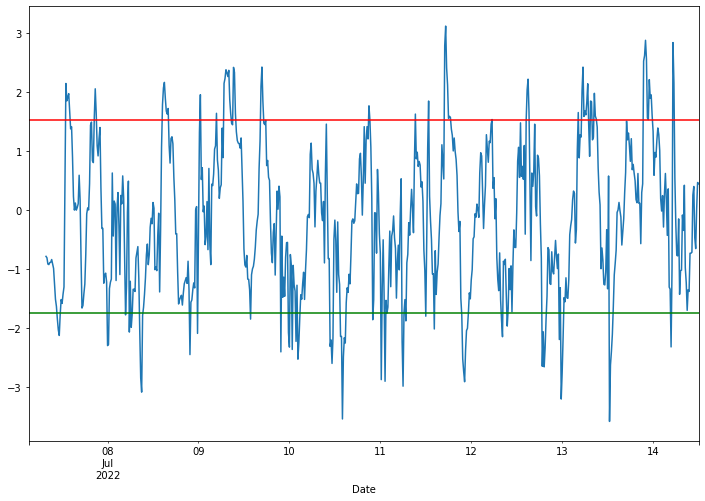

In [28]:
percentiles = np.percentile(backtester.pair_results.z_score.dropna(), [10, 90])
backtester.pair_results.z_score.plot(figsize=(12,8))
plt.axhline(y=percentiles[1], color='r', linestyle='-')
plt.axhline(y=percentiles[0], color='g', linestyle='-')
plt.show()

In [30]:
backtester.pair_results

,C98USDT_FUTURES,C98USDT_FUTURES_returns,SKLUSDT_FUTURES,SKLUSDT_FUTURES_returns,hr,spread,z_score,long_entry,long_exit,num_units_long,short_entry,short_exit,num_units_short,num_units,dailyret,gross,trades,net
Date,,,,,,,,,,,,,,,,,,
2022-07-07 03:15:00,0.5049,-0.000990,0.04724,0.001483,-0.008290,0.043055,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,0.0,NaN
2022-07-07 03:30:00,0.5054,0.000990,0.04729,0.001058,-0.013414,0.040510,NaN,False,False,0.0,False,False,0.0,0.0,0.0,1.000000,0.0,1.000000
2022-07-07 03:45:00,0.5056,0.000396,0.04736,0.001479,-0.016674,0.038929,NaN,False,False,0.0,False,False,0.0,0.0,0.0,1.000000,0.0,1.000000
2022-07-07 04:00:00,0.5035,-0.004162,0.04720,-0.003384,-0.018904,0.037682,NaN,False,False,0.0,False,False,0.0,0.0,0.0,1.000000,0.0,1.000000
2022-07-07 04:15:00,0.5030,-0.000994,0.04684,-0.007656,-0.020516,0.036520,NaN,False,False,0.0,False,False,0.0,0.0,0.0,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14 11:00:00,0.4382,-0.002962,0.04189,-0.006188,-0.030072,0.028713,-0.468986,False,False,1.0,False,False,-1.0,0.0,0.0,1.185455,0.0,1.116419
2022-07-14 11:15:00,0.4369,-0.002971,0.04179,-0.002390,-0.030072,0.028652,-0.654166,False,False,1.0,False,False,-1.0,0.0,0.0,1.185455,0.0,1.116419
2022-07-14 11:30:00,0.4390,0.004795,0.04199,0.004774,-0.030072,0.028788,0.018758,False,False,1.0,False,False,-1.0,0.0,0.0,1.185455,0.0,1.116419


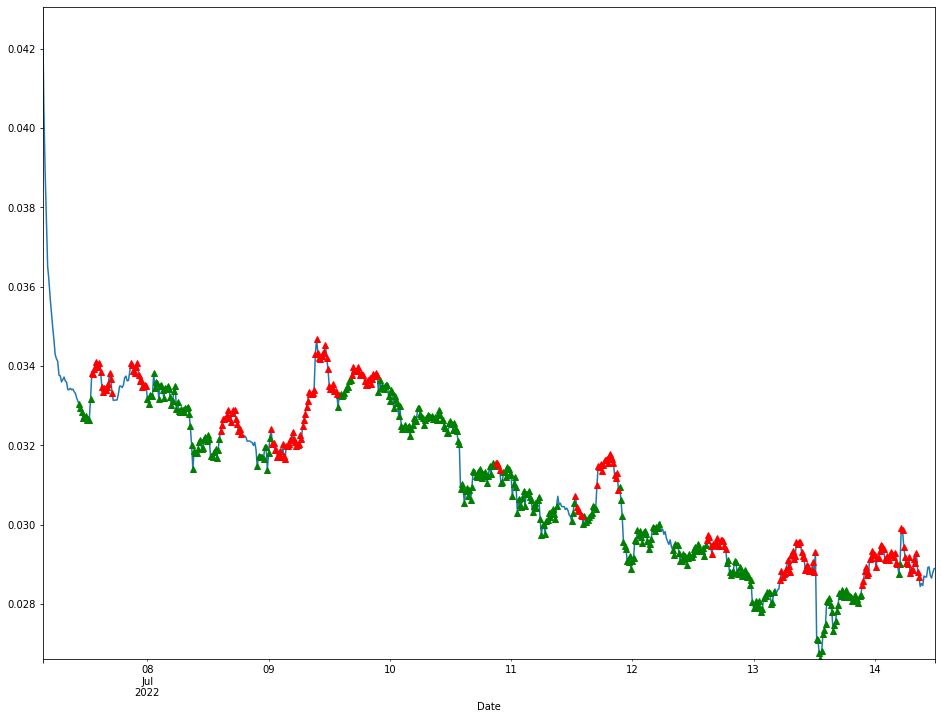

In [31]:
backtester.pair_results.spread.plot(figsize=(16, 12))

long = backtester.pair_results.spread.copy()
short = backtester.pair_results.spread.copy()
long[backtester.pair_results.num_units!=1] = 0
short[backtester.pair_results.num_units!=-1] = 0

long.plot(color='g', linestyle='None', marker='^')
short.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, backtester.pair_results.spread.min(), backtester.pair_results.spread.max()))

plt.show()

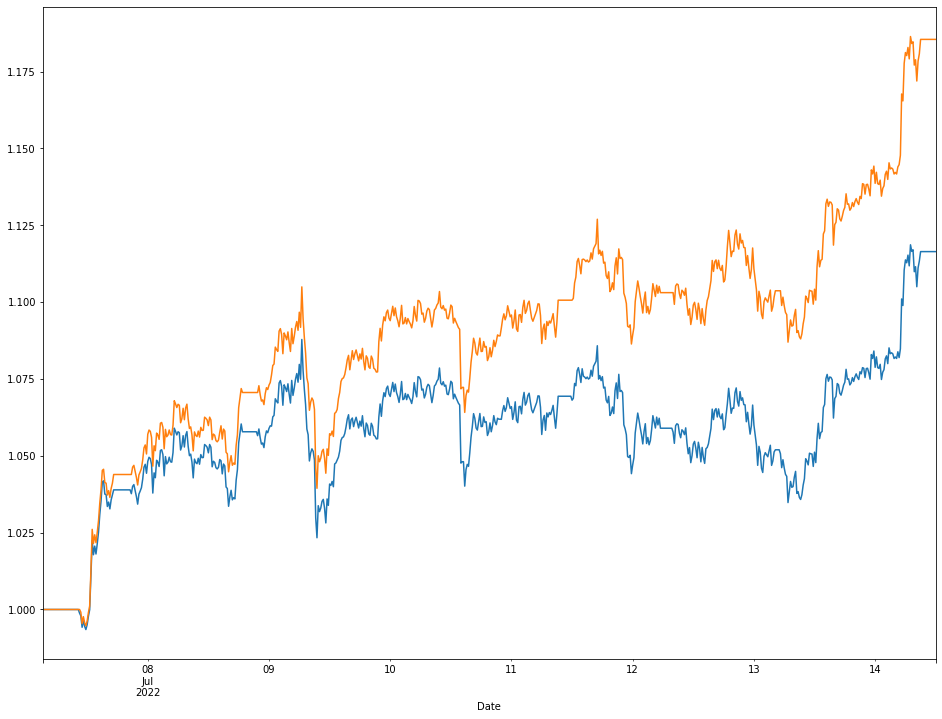

In [34]:
backtester.pair_results.net.plot(figsize=(16,12))
backtester.pair_results.gross.plot()
plt.show()